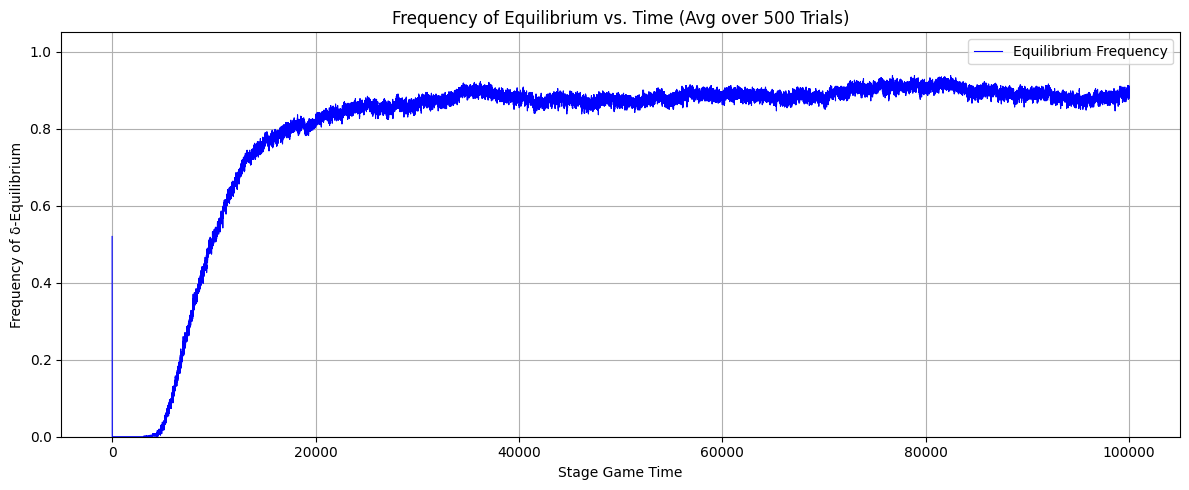


Table 1: Frequency at Select Time Points
t =      0 → Frequency = 0.520
t =  10000 → Frequency = 0.518
t =  20000 → Frequency = 0.806
t =  30000 → Frequency = 0.854
t =  40000 → Frequency = 0.874
t =  50000 → Frequency = 0.862
t =  75000 → Frequency = 0.912
t =  99999 → Frequency = 0.882


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

# --- Game structure from the paper ---
states = [0, 1]
actions = [0, 1]
num_agents = 2

# Transition kernel from paper
def transition(state, a0, a1):
    if state == 0:
        return np.random.choice([0, 1], p=[0.5, 0.5])
    elif state == 1:
        if a0 == a1:
            return np.random.choice([0, 1], p=[0.25, 0.75])
        else:
            return np.random.choice([0, 1], p=[0.9, 0.1])

# Cost matrix for each state
cost_matrix = {
    0: [[(0, 0), (2, 2)],
        [(2, 2), (0, 0)]],
    1: [[(10, 10), (11, 11)],
        [(11, 11), (10, 10)]]
}

# Parameters (from paper)
T = 100000
N_TRIALS = 500
T_base = 5000
R = 3
rho = [0.05, 0.05]
lambda_ = [0.2, 0.2]
delta = [0.5, 0.5]
alpha = [0.08, 0.08]

# δ-best response policy
def delta_best_response(Q, agent, delta_val):
    br_policy = []
    for s in states:
        qvals = Q[agent][s]
        min_val = np.min(qvals)
        br_actions = [a for a in actions if qvals[a] <= min_val + delta_val]
        br_policy.append(random.choice(br_actions))
    return np.array(br_policy)

# Check if current policies are δ-best-responses
def is_delta_equilibrium(Q, pi, delta):
    for i in range(num_agents):
        for s in states:
            qvals = Q[i][s]
            min_val = np.min(qvals)
            if qvals[pi[i][s]] > min_val + delta[i]:
                return False
    return True

# Main simulation
eq_at_t = np.zeros((N_TRIALS, T), dtype=int)

for trial in range(N_TRIALS):
    Q = [np.zeros((2, 2)) for _ in range(num_agents)]
    pi = [np.random.randint(0, 2, size=2) for _ in range(num_agents)]
    timer = [0, 0]
    phase_len = [random.randint(T_base, R * T_base) for _ in range(num_agents)]
    state = random.choice(states)

    for t in range(T):
        actions_taken = []
        for i in range(num_agents):
            a = pi[i][state] if random.random() > rho[i] else random.choice(actions)
            actions_taken.append(a)

        # Get cost and next state
        next_state = transition(state, actions_taken[0], actions_taken[1])
        for i in range(num_agents):
            a = actions_taken[i]
            cost_val = cost_matrix[state][actions_taken[0]][actions_taken[1]][i]
            Q[i][state][a] = (1 - alpha[i]) * Q[i][state][a] + alpha[i] * (cost_val + 0.8 * np.min(Q[i][next_state]))

        # Policy update
        for i in range(num_agents):
            timer[i] += 1
            if timer[i] >= phase_len[i]:
                br_pi = delta_best_response(Q, i, delta[i])
                if not np.array_equal(br_pi, pi[i]):
                    if random.random() > lambda_[i]:
                        pi[i] = br_pi
                timer[i] = 0
                phase_len[i] = random.randint(T_base, R * T_base)

        # Equilibrium check using δ-best-response
        eq_at_t[trial, t] = int(is_delta_equilibrium(Q, pi, delta))
        state = next_state

# Plot: average equilibrium frequency over time
avg_eq_freq = np.mean(eq_at_t, axis=0)

plt.figure(figsize=(12, 5))
plt.plot(avg_eq_freq, color="blue", linewidth=0.8, label='Equilibrium Frequency')
plt.title("Frequency of Equilibrium vs. Time (Avg over 500 Trials)")
plt.xlabel("Stage Game Time")
plt.ylabel("Frequency of δ-Equilibrium")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Table values
print("\nTable 1: Frequency at Select Time Points")
for t in [0, 10000, 20000, 30000, 40000, 50000, 75000, 99999]:
    print(f"t = {t:6d} → Frequency = {avg_eq_freq[t]:.3f}")